In [6]:
import pandas as pd
import re
import string
from spacy.lang.en import stop_words
import numpy as np
import bertopic
import simplemma
from pandarallel import pandarallel
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from textblob import TextBlob, Word, Blobber
from nltk.probability import FreqDist
import gensim.corpora as corpora
import gensim
from gensim.models import CoherenceModel

from pyLDAvis import gensim_models
import pickle 
import pyLDAvis
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from pprint import pprint

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
#import getpass
#APIKEY = getpass.getpass()
from googleapiclient.discovery import build
np.random.seed(1)

In [19]:
pandarallel.initialize(progress_bar=True,nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Functions

In [7]:
def translator(input):
  service = build('translate', 'v2', developerKey=APIKEY)
  # use the service
  inputs = [input.replace("\n","").replace("\r","").replace("\t","").strip()]
  outputs = service.translations().list(source='tr', target='en', q=inputs).execute()
  return outputs['translations']

def remove_stop_words(s):
  filtered_words = [i for i in s.split(" ") if i not in stop_words_list]
  clean_text = ' '.join(filtered_words)
  return clean_text

def transform_lemma(s):
  lang_data = simplemma.load_data("en")
  transformed_sent = []
  for tmp_word in s.split():
    cleaned = simplemma.lemmatize(tmp_word,lang_data)
    transformed_sent.append(cleaned)

  return " ".join(transformed_sent)

def clean_comments(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = s.replace("."," ")
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    s = s.replace("&#39;","'")

    s = s.translate(str.maketrans('', '', string.punctuation))
    

    s = s.replace("kaynak","").replace("\xa0"," ")\
    .replace("®","").replace("soure","")
    s = s.replace("toyota","").replace("toyota","")\
    .replace("hybrid","").replace("vehicle","").replace("corolla","")
    s= remove_stop_words(s)
    s= transform_lemma(s)

    return s.strip()
    
def find_lda_topic(x,id2word,corpus,lda_model,num_topics):
    
    bow = id2word.doc2bow(x.split())
    transform_document = lda_model.get_document_topics(bow)
    prediccted_topic = {i[0]:i[1] for i in transform_document}
    return max(prediccted_topic, key=prediccted_topic.get)

# 0. Business Understanding

Aim of this analysis to create a generic application using a machine learning algorithm to provide information to potential car buyers from public data.

# 1. Data Understanding

## Read Data

Reading saved and translated data.

In [12]:
eksi = pd.read_pickle("files/all_cars_en_cleaned_v3.pickle")
eksi_toyota = eksi[eksi.source=='toyota-corolla-hybrid']
sikayet = pd.read_pickle("files/sikayet_en.pickle")

In [13]:
eksi_toyota.shape

(236, 12)

In [23]:
eksi_toyota.head()

,comment,date,date_modified,author,source,comments_cleaned,comment_length,word_count,sentiment,sentiment_rounded,comment_lenght_binned,comment_en
0,türkiyede üretilecek otomobildir. kaynak,16.11.2018 23:45,NaN,sabir,toyota-corolla-hybrid,car produce turkey source,25,4,0.000000,0.0,"(-0.001, 62.0]",It is a car to be produced in Turkey. source
1,bugün lansmanı yapılan araç. fiyat konusunda a...,13.02.2019 20:33,NaN,ayvadana,toyota-corolla-hybrid,launch today think crazy price,30,5,-0.600000,-0.6,"(-0.001, 62.0]",vehicle launched today. I think they will go c...
2,toyota nın gösterip elletmediği yeni modelidir...,13.02.2019 22:14,NaN,thepcman,toyota-corolla-hybrid,new model show disclose obvious feature worldw...,98,14,0.045455,0.0,"(62.0, 125.0]",It is a new model that Toyota has shown or not...
3,"""lansmana özel"" fiyatları açıklanmış modeldirh...",14.02.2019 10:08,10:09,aydgn,toyota-corolla-hybrid,model launch special price announce vision ecv...,163,29,0.357143,0.4,"(125.0, 267.0]","Model with ""launch special"" prices announcedhy..."
4,hadi suv'yi falan 1.8 motor getiriyorsun hybri...,14.02.2019 10:22,10:22,sycrone one,toyota-corolla-hybrid,come bring suv engine buyer different mean bri...,271,44,-0.209881,-0.2,"(267.0, 3470.0]","Come on, you bring a SUV or something with a 1..."


In [14]:
sikayet.shape

(60, 3)

In [11]:
sikayet.head()

,comment,source,comment_en
0,Maalesef Toyota Efe Plazaya her gittiğimde ne...,https://www.sikayetvar.com,"Unfortunately, every time I go to Toyota Efe P..."
1,5 yıldır Toyota CHR Hybrid araç sahibiyim ve ...,https://www.sikayetvar.com,I have owned a Toyota CHR Hybrid vehicle for 5...
2,Toyota Corolla Cross hibrit satın almak istiy...,https://www.sikayetvar.com,"I want to buy Toyota Corolla Cross hybrid, the..."
3,Toyota Corolla hibrit aracım isletmesi fabrik...,https://www.sikayetvar.com,A screw was stuck in the tire of my Toyota Cor...
4,2019 model Hybrid Corolla aracımın ön göğüste...,https://www.sikayetvar.com,My 2019 model Hybrid Corolla vehicle had scrat...


### Translate Comments to English

In [ ]:
eksi['comment_en'] = eksi['comment'].apply(lambda x:translator(x)[0]['translatedText'])
sikayet['comment_en'] = sikayet['comment'].apply(lambda x:translator(x)[0]['translatedText'])

In [ ]:
# Save Turkish version
eksi.to_pickle("files/eksi_en.pickle")
sikayet.to_pickle("files/sikayet_en.pickle")
# Save English version
eksi = pd.read_pickle("files/eksi_en.pickle")
sikayet = pd.read_pickle("files/sikayet_en.pickle")

In [16]:
stop_words_list = stop_words.STOP_WORDS

In [17]:
transform_lemma(clean_comments(eksi_toyota.loc[4,'comment_en']))

'come bring suv 1 8 engine buyer different mean bring csegment 1 8 engine general user interest slice mtv crash market cry care people do prefer probably wont chance price high mtv issue disappointment cause previous case etc like disappointment horizon come hyundai ioniq'

In [20]:
eksi_toyota['comment_cleaned'] = eksi['comment_en'].parallel_apply(lambda x: clean_comments(x))
sikayet['comment_cleaned'] = sikayet['comment_en'].parallel_apply(lambda x: clean_comments(x))

Computing comment length and word counts

In [21]:
eksi_toyota['comment_length'] = eksi_toyota['comment_cleaned'].astype(str).apply(len)
eksi_toyota['word_count'] = eksi_toyota['comment_cleaned'].apply(lambda x: len(str(x).split()))

sikayet['comment_length'] = sikayet['comment_cleaned'].astype(str).apply(len)
sikayet['word_count'] = sikayet['comment_cleaned'].apply(lambda x: len(str(x).split()))

Computing each comment and compliant

In [22]:
eksi_toyota['sentiment'] = eksi_toyota['comment_cleaned'].map(lambda text: TextBlob(text).sentiment.polarity)
sikayet['sentiment'] = sikayet['comment_cleaned'].map(lambda text: TextBlob(text).sentiment.polarity)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb61ffab5e0>,
      dtype=object)

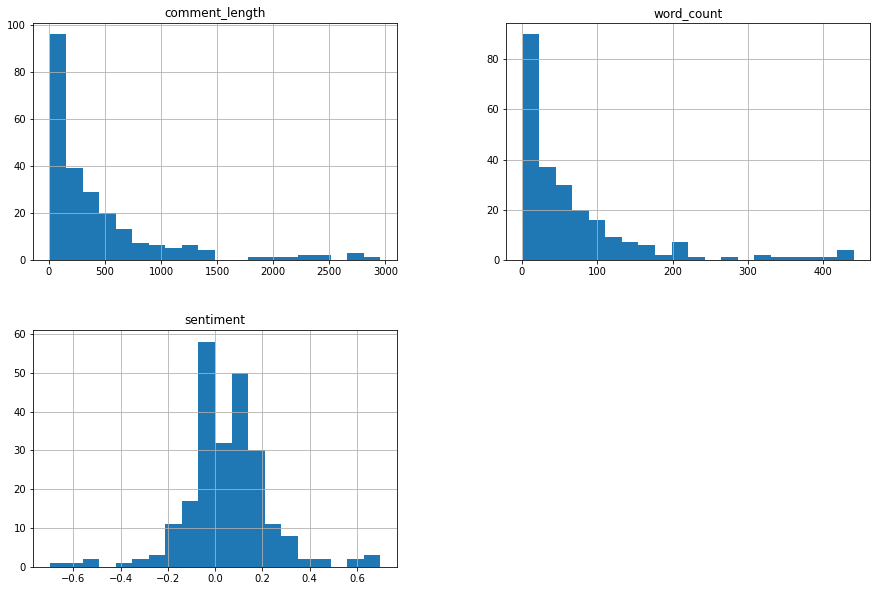

In [25]:
eksi_toyota[["comment_length", "word_count", "sentiment"]].hist(bins=20, figsize=(15, 10))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb619c9ab80>,
      dtype=object)

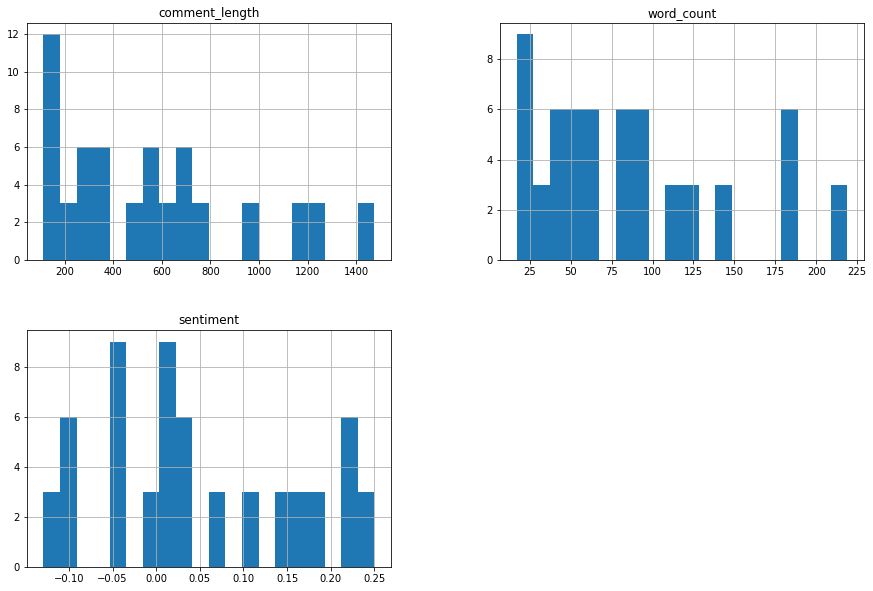

In [43]:
sikayet[["comment_length", "word_count", "sentiment"]].hist(bins=20, figsize=(15, 10))

In [23]:
eksi_toyota['sentiment_rounded']= eksi_toyota.sentiment.round(1)
sikayet['sentiment_rounded'] = sikayet.sentiment.round(1)

In [ ]:
eksi_toyota['comment_lenght_binned']= pd.qcut(eksi_toyota['comment_lenght'],q=[0, .25, .5, .75, 1.] )

In [24]:
sikayet['comment_lenght_binned']= pd.qcut(sikayet['comment_length'],q=[0, .25, .5, .75, 1.] )

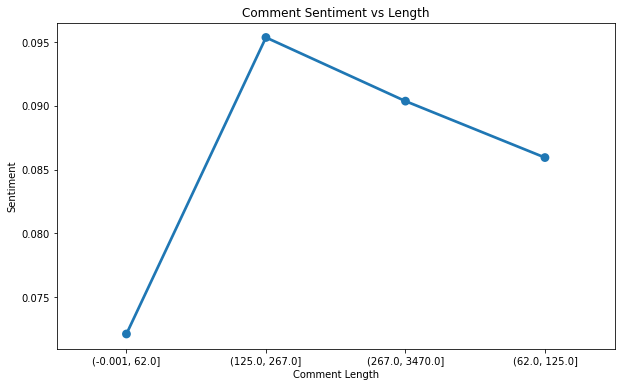

In [46]:
plt.figure(figsize=(10, 6))
sns.pointplot(x = "comment_lenght_binned", y = "sentiment_rounded",
              data = eksi.groupby('comment_lenght_binned').sentiment_rounded.mean().reset_index())
plt.ylabel("Sentiment")
plt.xlabel("Comment Length")
plt.title("Comment Sentiment vs Length")
plt.show()

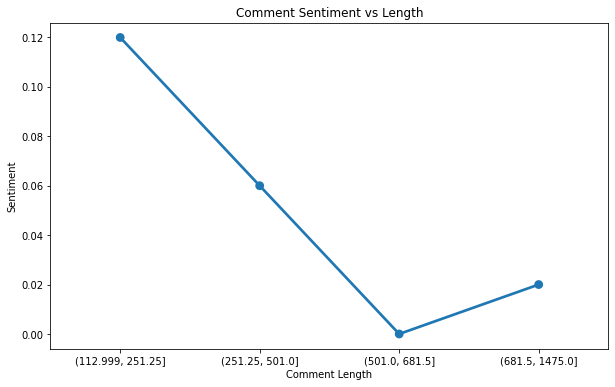

In [47]:
plt.figure(figsize=(10, 6))
sns.pointplot(x = "comment_lenght_binned", y = "sentiment_rounded",
              data = sikayet.groupby('comment_lenght_binned').sentiment_rounded.mean().reset_index())
plt.ylabel("Sentiment")
plt.xlabel("Comment Length")
plt.title("Comment Sentiment vs Length")
plt.show()

In [48]:
sikayet.to_csv('sikayet_en_computed.csv',sep=';')

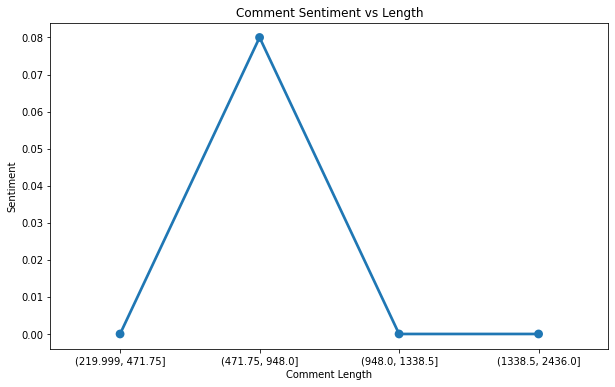

In [37]:
plt.figure(figsize=(10, 6))
sns.pointplot(x = "comment_lenght_binned", y = "sentiment_rounded",
              data = sikayet.groupby('comment_lenght_binned').sentiment_rounded.mean().reset_index())
plt.ylabel("Sentiment")
plt.xlabel("Comment Length")
plt.title("Comment Sentiment vs Length")
plt.show()

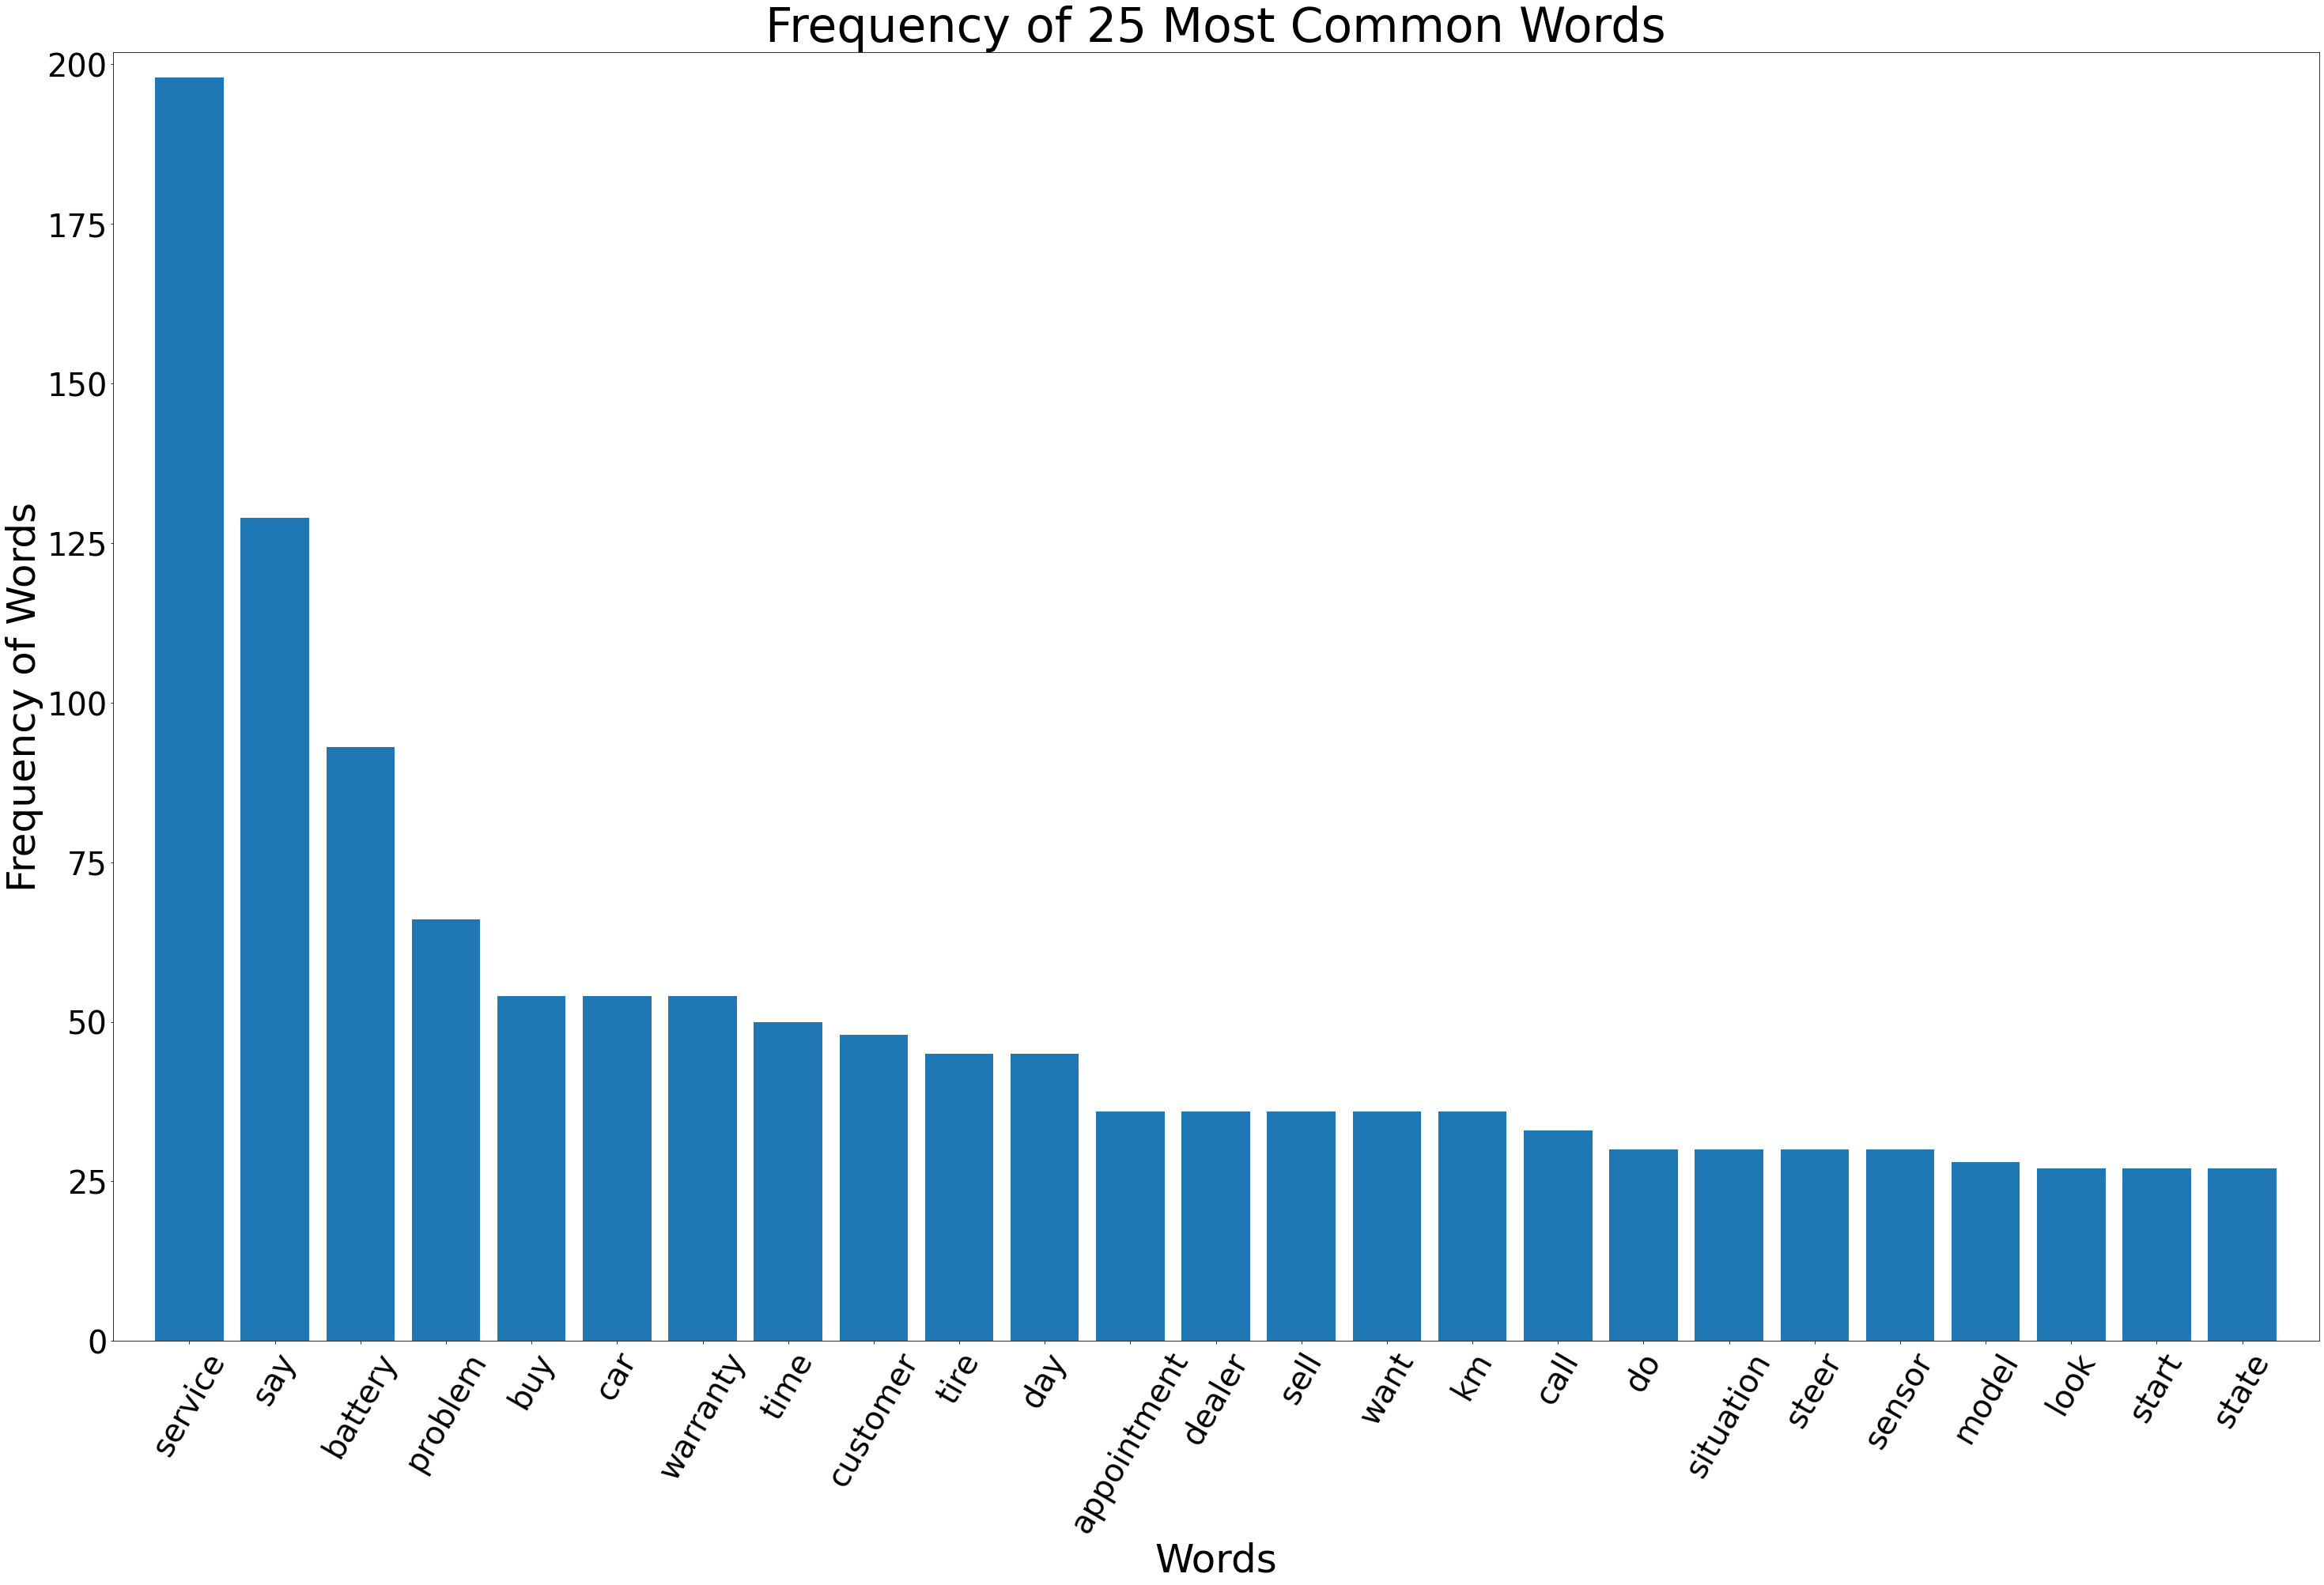

In [50]:
word_list_sikayet = list()
for sentence in sikayet.comment_cleaned.tolist():
  word_list_sikayet.extend(sentence.split())
mostcommon_words = FreqDist(word_list_sikayet).most_common(25)

mostcommon_words = FreqDist(word_list_sikayet).most_common(25)
x, y = zip(*mostcommon_words)

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [ ]:
# we need to see if the common word is also important, so we can use tfidf scoring.

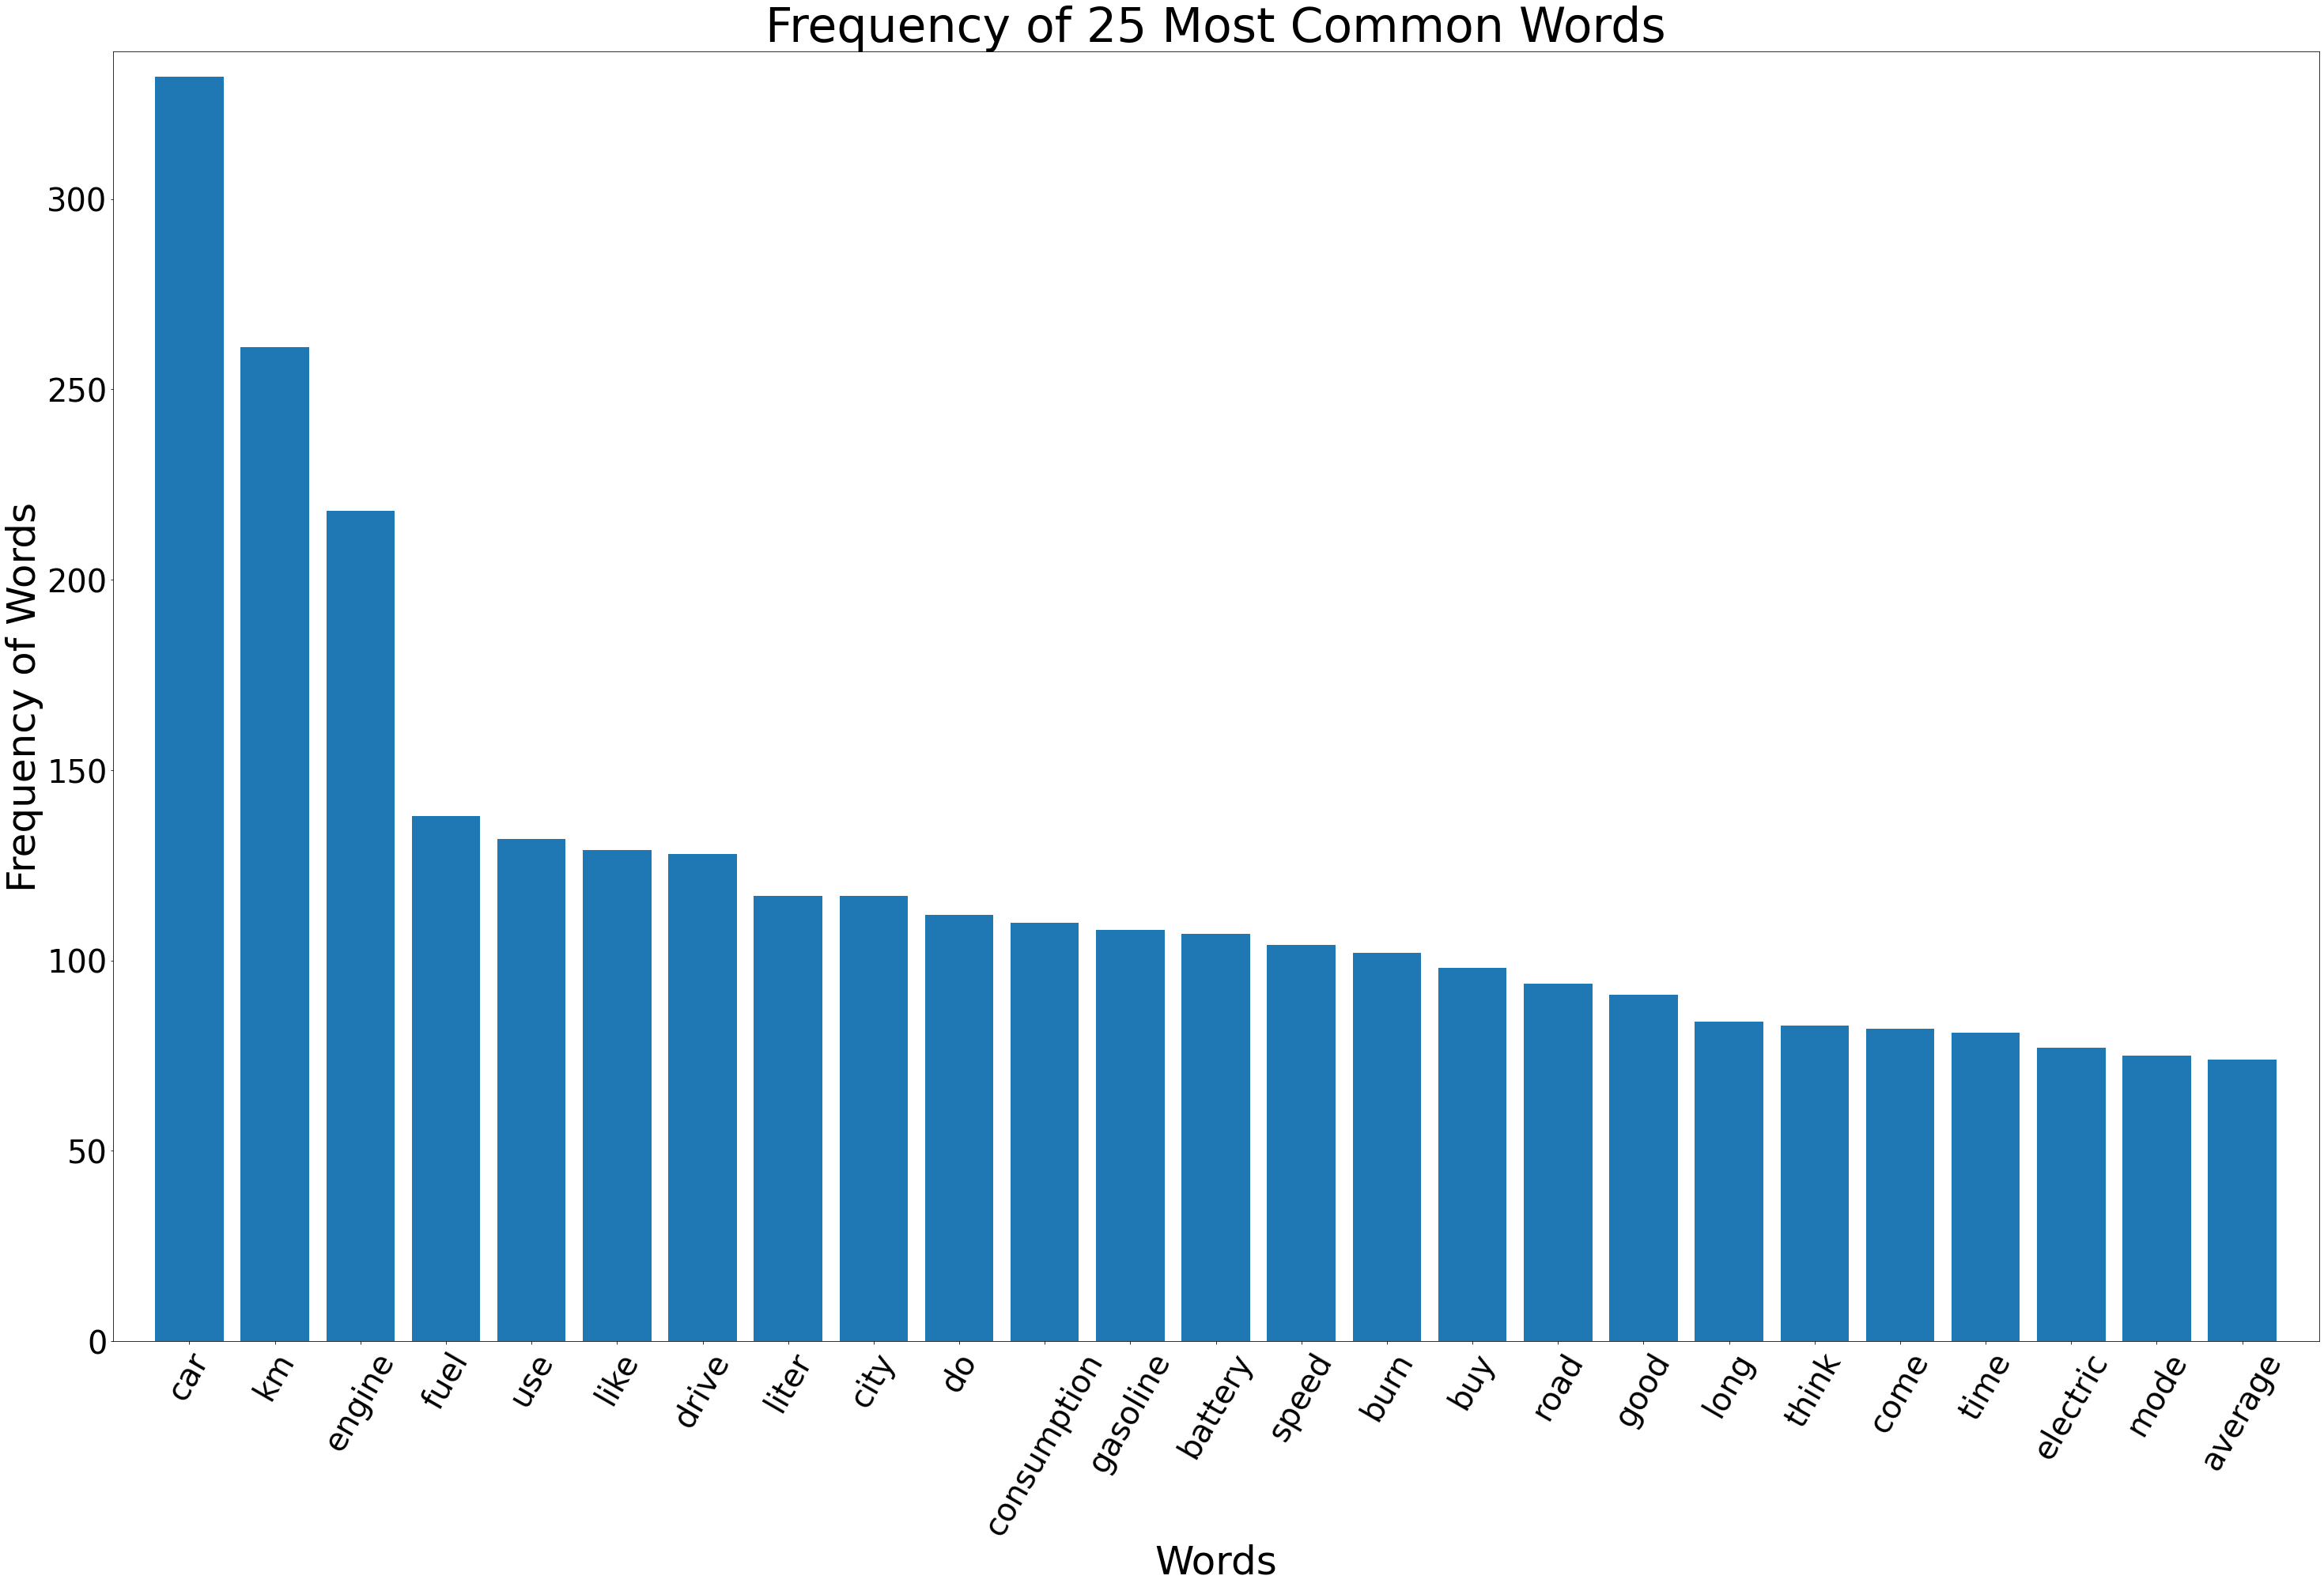

In [54]:
word_list_eksi = list()
for sentence in eksi_toyota.comments_cleaned.tolist():
  word_list_eksi.extend(sentence.split())

mostcommon_words = FreqDist(word_list_eksi).most_common(25)
mostcommon_words

x, y = zip(*mostcommon_words)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

# 2. Data Preparation

In [25]:
data_words_eksi = eksi_toyota.comments_cleaned.apply(lambda x: x.split()).tolist()
data_words_sikayet = sikayet.comment_cleaned.apply(lambda x: x.split()).tolist()

In [30]:
# Create Dictionary
id2word_eksi = corpora.Dictionary(data_words_eksi)
# Create Corpus
texts_eksi = data_words_eksi
# T-D  Frequency
corpus_eksi = [id2word_eksi.doc2bow(text) for text in texts_eksi]

In [31]:
# Create Dictionary
id2word_sikayet = corpora.Dictionary(data_words_sikayet)
# Create Corpus
texts_sikayet = data_words_sikayet
# T-D  Frequency
corpus_sikayet = [id2word_sikayet.doc2bow(text) for text in texts_sikayet]

## 3. Modeling 

In [32]:
num_topics = 3
# Build LDA model
lda_model_eksi = gensim.models.LdaMulticore(corpus=corpus_eksi,
                                       id2word=id2word_eksi,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model_eksi.print_topics())
doc_lda_eksi = lda_model_eksi[corpus_eksi]

[(0,
  '0.022*"car" + 0.013*"engine" + 0.010*"km" + 0.008*"like" + 0.008*"do" + '
  '0.008*"speed" + 0.007*"drive" + 0.007*"use" + 0.007*"city" + '
  '0.006*"battery"'),
 (1,
  '0.019*"car" + 0.018*"km" + 0.015*"engine" + 0.011*"fuel" + 0.009*"drive" + '
  '0.008*"liter" + 0.008*"consumption" + 0.008*"use" + 0.007*"like" + '
  '0.007*"city"'),
 (2,
  '0.017*"car" + 0.016*"km" + 0.008*"use" + 0.008*"engine" + 0.008*"fuel" + '
  '0.008*"buy" + 0.007*"liter" + 0.007*"like" + 0.006*"city" + 0.006*"burn"')]


In [33]:
# number of topics
num_topics = 3
# Build LDA model
lda_model_sikayet = gensim.models.LdaMulticore(corpus=corpus_sikayet,
                                       id2word=id2word_sikayet,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model_sikayet.print_topics())
doc_lda = lda_model_sikayet[corpus_sikayet]

[(0,
  '0.038*"service" + 0.022*"say" + 0.012*"warranty" + 0.012*"problem" + '
  '0.012*"battery" + 0.010*"buy" + 0.010*"customer" + 0.010*"car" + '
  '0.009*"tire" + 0.009*"time"'),
 (1,
  '0.021*"service" + 0.019*"say" + 0.015*"problem" + 0.013*"battery" + '
  '0.010*"tire" + 0.009*"time" + 0.009*"buy" + 0.009*"model" + 0.009*"look" + '
  '0.009*"car"'),
 (2,
  '0.040*"service" + 0.025*"say" + 0.023*"battery" + 0.010*"day" + 0.009*"car" '
  '+ 0.009*"appointment" + 0.009*"buy" + 0.008*"time" + 0.008*"problem" + '
  '0.008*"charge"')]


# 4. Evaluation

### Eksisozluk Comments

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('files/ldavis_prepared_eksi'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared_eksi = gensim_models.prepare(lda_model_eksi, corpus_eksi, id2word_eksi)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_eksi, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared_eksi = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared_eksi, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared_eksi

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010187 -0.007323       1        1  52.893195
0     -0.012102 -0.004322       2        1  27.877388
2      0.001915  0.011645       3        1  19.229418, topic_info=         Term        Freq       Total Category  logprob  loglift
0         car  284.000000  284.000000  Default  30.0000  30.0000
111       buy   79.000000   79.000000  Default  29.0000  29.0000
128        km  229.000000  229.000000  Default  28.0000  28.0000
142  thousand   53.000000   53.000000  Default  27.0000  27.0000
209        tl   48.000000   48.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
109   battery   14.272160   94.917399   Topic3  -5.2993  -0.2460
188     drive   15.058051  115.265977   Topic3  -5.2457  -0.3866
292     speed   13.330316   90.563032   Topic3  -5.3675  -0.2673
260      time   12.102618   69.325307   Topic3  -5.4641  -0.0967
97   electric   11.517399   65.754156   Topic3  -5.5137  -0.0933

[264 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
961       1  0.362470  advantageous
961       2  0.543706  advantageous
961       3  0.181235  advantageous
1629      1  0.711900  aggressively
1760      3  0.708692      american
...     ...       ...           ...
147       3  0.244738          year
699       1  0.256606          zero
699       2  0.427676          zero
699       3  0.256606          zero
2113      3  0.708794       üsküdar

[375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### Compute Perplexity and Coherence Score

In [40]:
## Perplexity
print('Perplexity: ', lda_model_eksi.log_perplexity(corpus_eksi).round(3))  


## Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_eksi, texts=data_words_eksi, dictionary=id2word_eksi, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda.round(3))

Perplexity:  -7.215
Coherence Score:  0.286


* Lower the perplexity better the model
* Higher the topic coherence, the topic is more interpretable

## Sikayetvar Complaints

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('files/ldavis_prepared_sikayet'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared_sikayet = gensim_models.prepare(lda_model_sikayet, corpus_sikayet, id2word_sikayet)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_sikayet, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared_sikayet = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared_sikayet, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared_sikayet

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.026617 -0.007433       1        1  41.703774
0     -0.004545  0.012027       2        1  29.909173
1      0.031163 -0.004594       3        1  28.387053, topic_info=          Term       Freq      Total Category  logprob  loglift
190      model  25.000000  25.000000  Default  30.0000  30.0000
331      brake  15.000000  15.000000  Default  29.0000  29.0000
41        look  24.000000  24.000000  Default  28.0000  28.0000
320  available   8.000000   8.000000  Default  27.0000  27.0000
192    problem  57.000000  57.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
223   customer  10.566609  42.353274   Topic3  -4.9337  -0.1291
198  situation   8.321209  27.702933   Topic3  -5.1726   0.0565
224        day   8.745577  41.435492   Topic3  -5.1228  -0.2964
40        like   7.465964  22.167753   Topic3  -5.2810   0.1710
293      check   7.104032  21.907540   Topic3  -5.3307   0.1331

[226 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
72        1  0.724856    000
72        3  0.289942    000
201       1  0.370812     10
201       2  0.556218     10
201       3  0.092703     10
...     ...       ...    ...
71        3  0.276237   year
471       1  0.295690    yes
471       2  0.591381    yes
471       3  0.295690    yes
646       2  0.649625  youre

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Compute Perplexity and Coherence Score

In [39]:
## Perplexity
print('Perplexity: ', lda_model_sikayet.log_perplexity(corpus_sikayet).round(3))  


## Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_sikayet, texts=data_words_sikayet, dictionary=id2word_sikayet, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda.round(3))

Perplexity:  -6.282
Coherence Score:  0.254


* Lower the perplexity better the model
* Higher the topic coherence, the topic is more interpretable.

In [75]:
eksi_toyota['lda_topic']=eksi_toyota['comments_cleaned'].apply(lambda x:find_lda_topic(x) )
sikayet['lda_topic']=sikayet['comment_cleaned'].apply(lambda x:find_lda_topic(x) )

In [77]:
eksi_toyota.lda_topic.value_counts(normalize=True)

0.0    0.559322
2.0    0.283898
1.0    0.156780
Name: lda_topic, dtype: float64

In [76]:
sikayet.lda_topic.value_counts(normalize=True)

0.0    0.50
1.0    0.25
2.0    0.25
Name: lda_topic, dtype: float64

# 5. Deployment

You can follow the instructions on README.md file and run "streamlit run run.py" to access the application.